# Oxford: Smooth fit to log-odds ratios

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
import json 
with open("data/data.json") as file:
    data = json.load(file)
    
with open("data/init.json") as file:
    init = json.load(file)
    
with open("data/params.json") as file:
    params = json.load(file)

In [21]:
for idx, item in data.items():
    data[idx] = np.array(item).reshape(-1)

for idx, item in init.items():
    init[idx] = np.array(item).reshape(-1)

for idx, item in params.items():
    params[idx] = np.array(item).reshape(-1)

In [22]:
data["year2"] = np.power(data["year"], 2) - 22
init["tau"] = init["sigma_sq"]
del init["sigma_sq"]

In [23]:
df = pd.DataFrame(data)

In [137]:
params["tau_a"] = 1e-3
params["tau_b"] = 1e-3

params["var"] = 1e6

params["mu_sd_proposal"] = 1e3
params["alpha_sd_proposal"] = 50
params["beta1_sd_proposal"] = .5
params["beta2_sd_proposal"] = .5
params["b_sd_proposal"] = 100

In [138]:
df["r_sum"] = df.r0 + df.r1
df["n_sum"] = df.n0 + df.n1
df["nr_sum_diff"] = df.n_sum - df.r_sum
df["n1r1_diff"] = df.n1 - df.r1

In [139]:
df

,r1,n1,r0,n0,year,year2,r_sum,n_sum,nr_sum_diff,n1r1_diff
0,3,28,0,28,-10,78,3,56,53,25
1,5,21,2,21,-9,59,7,42,35,16
2,2,32,2,32,-9,59,4,64,60,30
3,7,35,1,35,-8,42,8,70,62,28
4,7,35,2,35,-8,42,9,70,61,28
...,...,...,...,...,...,...,...,...,...,...
115,5,51,2,51,8,42,7,102,95,46
116,7,42,4,42,8,42,11,84,73,35
117,6,46,6,46,9,59,12,92,80,40
118,3,54,4,54,9,59,7,108,101,51


In [140]:
from pprint import pprint
def sampler(nchain, data, init, params):
    
    # initialisation de la chaîne
    chain = dict()
    for param_name, param_init in init.items():
        chain[param_name] = np.zeros((nchain+1, param_init.shape[0]))
        chain[param_name][0, :] = param_init
        
    # définition des hyper-paramètres
    K = int(params["K"])
    
    tau_a = params["tau_a"]
    tau_b = params["tau_b"]
    
    var = params["var"]
    
    mu_sd_proposal = params["mu_sd_proposal"]
    alpha_sd_proposal = params["alpha_sd_proposal"]
    beta1_sd_proposal = params["beta1_sd_proposal"]
    beta2_sd_proposal = params["beta2_sd_proposal"]
    b_sd_proposal = params["b_sd_proposal"]
    
    for i in range(1, nchain+1):
        print(i, end=" ")
        ## mise à jour de mu 
        mu_current = chain["mu"][i-1, :]
        alpha_current = chain["alpha"][i-1, :]
        beta1_current = chain["beta1"][i-1, :]
        beta2_current = chain["beta2"][i-1, :]
        b_current = chain["b"][i-1, :]
        
        logpsi_current = alpha_current + beta1_current * data.year + beta2_current*data.year2 + b_current
    
        mu_proposal = mu_current + np.random.normal(scale=mu_sd_proposal, size=K)
        
        mu_top = - mu_proposal / (2*var) - data.nr_sum_diff * mu_proposal
        mu_top = mu_top - data.n0 * np.log1p(np.exp(-mu_proposal))
        mu_top = mu_top - data.n1 * np.log1p(np.exp(-mu_proposal -logpsi_current))
        
        mu_bottom = - mu_current / (2*var) - data.nr_sum_diff * mu_current
        mu_bottom = mu_top - data.n0 * np.log1p(np.exp(-mu_current))
        mu_bottom = mu_top - data.n1 * np.log1p(np.exp(-mu_current-logpsi_current))
        
        mu_acceptance = np.exp(mu_top - mu_bottom)
        
        mu_accept_mask = (mu_acceptance > np.random.rand())
        mu_current[mu_accept_mask] = mu_proposal[mu_accept_mask]
        
        chain["mu"][i, :] = mu_current
        
        ## mise à jour de alpha
        alpha_proposal = alpha_current + np.random.normal(scale=alpha_sd_proposal)
        logpsi_proposal = logpsi_current + (alpha_proposal - alpha_current)
        
        alpha_top = - np.power(alpha_proposal, 2) / (2*var)
        alpha_top = alpha_top - np.sum(logpsi_proposal * data.n1r1_diff)
        alpha_top = alpha_top - np.sum(data.n1 * np.log1p(np.exp(-mu_current-logpsi_proposal)))
        
        alpha_bottom = - np.power(alpha_current, 2) / (2*var) 
        alpha_bottom = alpha_bottom - np.sum(logpsi_current * data.n1r1_diff)
        alpha_bottom = alpha_bottom - np.sum(data.n1 * np.log1p(np.exp(-mu_current-logpsi_current)))
        
        alpha_acceptance = np.exp(alpha_top - alpha_bottom)
        if alpha_acceptance > np.random.rand():
            chain["alpha"][i, :] = alpha_proposal
            alpha_current = alpha_proposal
            logpsi_current = logpsi_proposal
        else:
            chain["alpha"][i, :] = alpha_current
        
        ## mise à jour de beta1
        beta1_proposal = beta1_current + np.random.normal(scale=beta1_sd_proposal)
        logpsi_proposal = logpsi_current + (beta1_proposal - beta1_current)* data.year
        
        beta1_top = - np.power(beta1_proposal, 2) / (2*var)
        beta1_top = beta1_top - np.sum(logpsi_proposal * data.n1r1_diff)
        beta1_top = beta1_top - np.sum(data.n1 * np.log1p(np.exp(-mu_current-logpsi_proposal)))
        
        beta1_bottom = - np.power(beta1_current, 2) / (2*var)
        beta1_bottom = beta1_bottom - np.sum(logpsi_current * data.n1r1_diff)
        beta1_bottom = beta1_bottom - np.sum(data.n1 * np.log1p(np.exp(-mu_current-logpsi_current)))
        
        beta1_acceptance = np.exp(beta1_top - beta1_bottom)
        if beta1_acceptance > np.random.rand():
            chain["beta1"][i, :] = beta1_proposal
            beta1_current = beta1_proposal
            logpsi_current = logpsi_proposal
        else:
            chain["beta1"][i, :] = beta1_current
        
        ## mise à jour de beta2
        beta2_proposal = beta2_current + np.random.normal(scale=beta2_sd_proposal)
        logpsi_proposal = logpsi_current + (beta2_proposal - beta2_current) * data.year2
        
        beta2_top = - np.power(beta2_proposal, 2) / (2*var)
        beta2_top = beta2_top - np.sum(logpsi_proposal * data.n1r1_diff)
        beta2_top = beta2_top - np.sum(data.n1 * np.log1p(np.exp(-mu_current-logpsi_proposal)))
        
        beta2_bottom = - np.power(beta2_current, 2) / (2*var)
        beta2_bottom = beta2_bottom - np.sum(logpsi_current * data.n1r1_diff)
        beta2_bottom = beta2_bottom - np.sum(data.n1 * np.log1p(np.exp(-mu_current-logpsi_current)))
        
        beta2_acceptance = np.exp(beta2_top - beta2_bottom)
        if beta2_acceptance > np.random.rand():
            chain["beta2"][i, :] = beta2_proposal
            beta2_current = beta2_proposal
            logpsi_current = logpsi_proposal
        else:
            chain["beta2"][i, :] = beta2_current
        
        ## mise à jour de b
        tau_current = chain["tau"][i-1,:]
        b_proposal = b_current + np.random.normal(scale=b_sd_proposal, size=K)
        logpsi_proposal = logpsi_current + (b_proposal - b_current)
        
        b_top = - (tau_current / 2) * np.power(b_proposal, 2)
        b_top = b_top - np.sum(logpsi_proposal * data.n1r1_diff)
        b_top = b_top - np.sum(data.n1 * np.log1p(np.exp(-mu_current-logpsi_proposal)))
        
        b_bottom = - (tau_current / 2) * np.power(b_current, 2)
        b_bottom = b_bottom - np.sum(logpsi_current * data.n1r1_diff)
        b_bottom = b_bottom - np.sum(data.n1 * np.log1p(np.exp(-mu_current-logpsi_current)))
        
        b_acceptance = np.exp(b_top - b_bottom)
        b_accept_mask = (b_acceptance > np.random.rand())
        b_current[b_accept_mask] = b_proposal[b_accept_mask]
        logpsi_current[b_accept_mask] = logpsi_proposal[b_accept_mask]
        
        chain["b"][i, :] = b_current
        
        ## mise à jour de tau
        tau_proposal = np.random.gamma(tau_a + K/2, 1/(tau_b+np.sum(np.power(b_current,2))/2))
        chain["tau"][i, :] = tau_proposal
        
    return chain

In [141]:
chain = sampler(1000, df, init, params)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

/tmp/ipykernel_4129/2458551064.py:38: RuntimeWarning: overflow encountered in exp
  mu_top = mu_top - data.n0 * np.log1p(np.exp(-mu_proposal))
/home/meh/anaconda3/envs/minimal/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_4129/2458551064.py:84: RuntimeWarning: overflow encountered in exp
  beta1_acceptance = np.exp(beta1_top - beta1_bottom)
/tmp/ipykernel_4129/2458551064.py:104: RuntimeWarning: overflow encountered in exp
  beta2_acceptance = np.exp(beta2_top - beta2_bottom)
/tmp/ipykernel_4129/2458551064.py:64: RuntimeWarning: overflow encountered in exp
  alpha_acceptance = np.exp(alpha_top - alpha_bottom)


25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 

/tmp/ipykernel_4129/2458551064.py:125: RuntimeWarning: overflow encountered in exp
  b_acceptance = np.exp(b_top - b_bottom)


54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 31

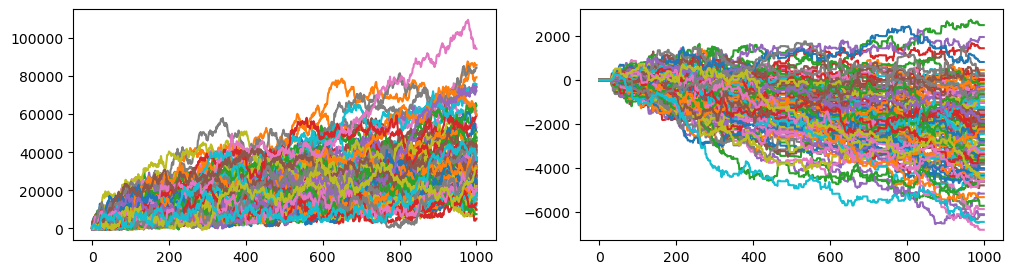

In [142]:
fig, axs = plt.subplots(1, 2, figsize=(12,3))
axs[0].plot(chain["mu"])
axs[1].plot(chain["b"])
plt.show()

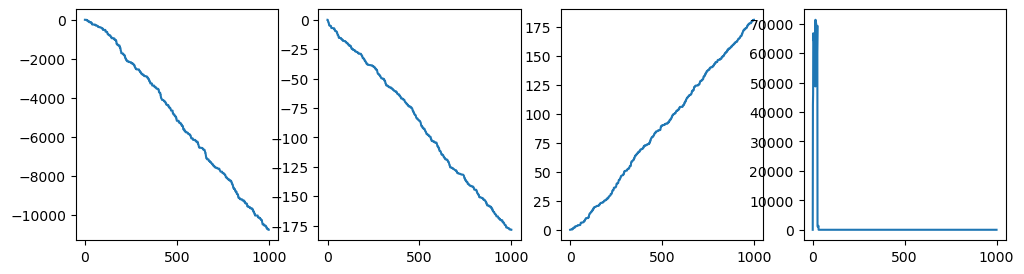

In [143]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
axs[0].plot(chain["alpha"])
axs[1].plot(chain["beta1"])
axs[2].plot(chain["beta2"])
axs[3].plot(chain["tau"])
plt.show()